<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch5_6~7_pg_319~334_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#파이썬 머신러닝 완벽가이드 ch5. 6 ~ 7 pg. 319 ~ 334 필사

##06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

###규제 선형 모델의 개요

-회귀모델은 적절히 데이터에 적합하면서도 회귀계수가 기하급수적으로 커지는 것 제어해야함-> 비용함수: rss최소화방법&과적합 방지-> 학습데이터 잔차 오류 최소화 + 회귀계수 크기 제어

비용함수 목표 = MIN(RSS(W)+alpha*||W||)

-> alpha: 0또는 매우 작은 값이면 비용함수식은 기존과 동일한 MIN(RSS(W)+0) 이고 무한대 또는 매우 큰 값이면 W값을 매우 작게 만들어야 cost가 최소화되는 비용함수 목표 달성 가능

-> alpha 값 크게하면 비용함수는 회귀계수w의 값을 작게해 과적합개선 가능, 작을 경우 rss(w) 최소화

### 릿지 회귀

사이킷런 Ridge 클래스, 주요 생성 파라미터: alpha(alpha L2 규제 계수)



In [2]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

Boston 데이터 세트 크기: (506, 14)


In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0: .3f}' .format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE :  5.518


릿지의 5개 폴드 세트의 평균 RMSE가 5.518로 앞의 linearRegression RMSE 보다 낮으므로 더 뛰어난 예측 성능 보임

-> 릿지의 ALPHA 값 변화시키면서 RMSE와 회귀계수 값의 변화 살펴보기

In [4]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
  ridge = Ridge(alpha=alpha)

  #cross_val_score를 이용해 5폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE: 5.829
alpha 0.1일 때 5 folds의 평균 RMSE: 5.788
alpha 1일 때 5 folds의 평균 RMSE: 5.653
alpha 10일 때 5 folds의 평균 RMSE: 5.518
alpha 100일 때 5 folds의 평균 RMSE: 5.330


alpha 100일때 평균 RMSE가 가장 좋음

alpha 값의 변화에 따른 피처의 회귀계수 값을 가로막대 그래프로 시각화

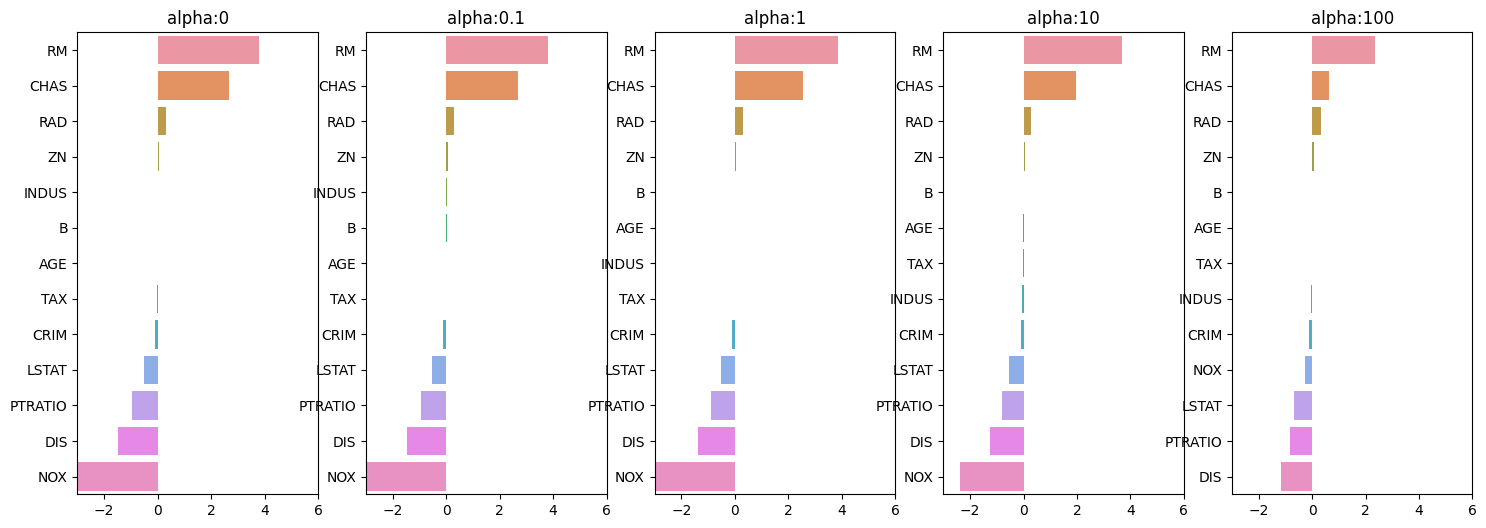

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_data, y_target)

  # alpha에 따른 피처별로 회귀 계수를 series로 변환하고 이를 df의 칼럼으로 추가
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname = 'alpha:'+str(alpha)
  coeff_df[colname] = coeff

  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])


# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame로 표시
plt.show()

alpha값 증가시킬수록 회귀계속값 작아짐(특히 NOX)

DataFrame에 저장된 alpha값의 변화에 따른 릿지회귀계수값 구해보기

In [6]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha값 증가하면서 회귀계수 계속 작아짐(회귀계수가 0이 되진 않음)

###라쏘회귀

W의 절댓값에 페널티를 부여하는 L1 규제를 선형회귀에 적용한 것

L1규제는 불필요한 회귀계수를 급격하게 감소시켜 0으로 만들고 제거, 적절한 피처만 회귀에 포함시키는 피처 선택의 특성 가짐

주요 생성 파라미터: ALPHA(ALPHA L1 규제 계수)

In [8]:
from sklearn.linear_model import Lasso, ElasticNet

#alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
  coeff_df = pd.DataFrame()
  if verbose : print('####### ', model_name, '#######')
  for param in params:
    if model_name == 'Ridge':model = Ridge(alpha=param)
    elif model_name == 'Lasso':model = Lasso(alpha=param)
    elif model_name == 'ElasticNet':model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))

    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data, y_target)

    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
    coeff = pd.Series(data=model.coef_, index=X_data.columns)
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
  return coeff_df
#end of get_linear_regre_eval

In [10]:
#alpha값의 변화에 따른 RMSE와 그때의 회귀계수 출력

#라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


alpha 0.07일때 가장 좋은 평균 RMSE 보여줌

alpha 값에 따른 피처별 회귀 계수

In [11]:
#반환된 coeff_lasso_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha크기가 증가함에 따라 일부 피처 회귀계수는 아예 0 으로 바뀜(nox 0으로), 회귀계수가 0 인 피처는 회귀식에서 제외되면서 피처 선택의 효과 얻을 수 있음

###엘라스틱넷 회귀

L1규제와 L2규제 결합한 회귀

비용함수 목표 : RSS(W)+ alpha2*||W||2+ alpha1*||W||1 을 최소화하는 W 찾기

중요 피처만 셀렉션하고 다른 피처 모두 회귀계수 0으로 만드는 성향이 강해 이로 인해 alpha 값에 따라 회귀계수값이 급격히 변동할 수 있는데 이를 완화하기 위해 L2 규제를 라쏘회귀에 추가한것

ElasticNet 클래스: alpha, l1_ratio

엘라스틱넷의 규제: a(L1규제의 ALPHA값)*L1+b(L2규제의 ALPHA 값)*L2

l1_ratio가 0이면 a가 0으로 L2규제와 동일, 1이면 b가 0으로 L1규제와 동일

-> alpha 값 변화시키며 RMSE와 각 피처의 회귀계수 출력해보기 (l1_ration 고정)

In [12]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X_data, y_target_n = y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [13]:
# 반환된 coeff_elastic_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 Datarame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha 0.5일때 RMSE가 가장좋은 예측 성능 보임

alpha값에 따른 피처들의 회귀계수들 값이 라쏘보다 상대적으로 0 이 되는 값이 적음 알 수 있음

릿지, 라쏘, 엘라스틱넷 회귀-> 하이퍼파라미터 변경해 가면서 최적의 예측 성능 찾아내기, 데이터분포도의 정규화와 인코딩 방법 중요

###선형 회귀 모델을 위한 데이터 변호나

선형 회귀 모델 적용 전 데이터 스케일링/정규화 작업 수행(중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 경우 변환 작업 수행)

1. StandardScaler 클래스 이용해 평균 0, 분산 1인 표준 정규분포로 변환, 또는 MinMaxScaler 클래스 이용해 최솟값 0, 최댓값 1인 정규화 수행

2. 스케일링/정규화 수행한 데이터세트에 다시 다항 특성 적용해 변환(1번통해 성능향상 없을경우)

3. 원래 값에 log 함수 적용시 정규분포에 더 가까워짐: 로그 변환

타깃값: 로그 변환 적용

표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그변환 차례 적용후 RMSE로 각 경우별 예측 성능 측정

In [14]:
# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p-degree는 다항식 특성을 추가할 때 적용. p-degree는 2 이상 부여하지 않음.

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data

Ridge 클래스의 alpha값 변화시키면서 피처 데이터 세트를 변환한 데이터 세트 입력받을 경우 RMSE 어떻게 변화하는지 보기

In [15]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그 변환

scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = X_data)
    print('\n## 변환 유형 : {0}, Polynomial Degree : {1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params = alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose=False)


## 변환 유형 : None, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 

## 변환 유형 : Standard, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 

## 변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 

## 변환 유형 : MinMax, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 

## 변환 유형 : MinMax, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538 

## 변환 유형 : Log, Polynomial Degree

로그변환 성능 향상-> 선형회귀 적용하려는 데이터 세트에 데이터값의 분포가 심하게 왜곡 되어있을 경우에 로그변환 적용하는 것이 좋은결과 기대 가능

## 07 로지스틱 회귀

선형 회귀 계열, 독립변수가 아닌 가중치 변수가 선형

선형 함수의 회귀 최적선을 찾는 것이 아닌 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환값을 확률로 간주해 확률에 따라 분류 결정

시그모이드 함수: y=1/(1+e^(-x))

분류 문제에 적용: 종양 크기에 따른 악성 종양 여부 예측

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#StandardSclaer()로 평균이 0, 분산이 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

#로지스틱 회귀를 이용해 학습 및 예측 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

#정확도와 roc_auc 측정
print('accuracy : {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy : 0.977
roc_auc: 0.972


사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터: penalty(규제의 유형 설정해 l2로 설정시 L2규제, l1으로 설정시 L1 규제를 뜻함-default l2), C(규제 강도 조절하는 alpha값의 역수, 작을수록 규제 강도 큼)

GridSearchCV 이용해 위스콘신 데이터 세트에서 하이퍼 파라미터 최적화

In [19]:
from sklearn.model_selection import GridSearchCV

params = {'penalty':['l2', 'l1'], 'C': [0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도0.975


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

로지스틱 회귀 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어남, 희소한 데이터 세트 분류에도 성능 뛰어남-> 이진 분류 기본 모델과 텍스트 분류에서 많이 사용